In [1]:
import feather
import os
from pathlib import Path
import pandas as pd
import numpy as np
import category_encoders
import re
import gc

from pandas.api.types import CategoricalDtype
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Load data 

In [2]:
%%time

data_DIR = Path('/Users/xszpo/Google Drive/DataScience/Projects/201908_credit/'
                '01_data')

df_train = feather.read_dataframe(os.path.join(data_DIR, 'DS_loans_IN_train.feather'))

df_test = feather.read_dataframe(os.path.join(data_DIR, 'DS_loans_IN_test.feather'))

df_variables = feather.read_dataframe(os.path.join(data_DIR, 'variables_primary_selection.feather'))


CPU times: user 1.24 s, sys: 639 ms, total: 1.88 s
Wall time: 1.23 s


In [3]:
print(df_train.shape)
print(df_test.shape)
print(df_variables.shape)

(714794, 93)
(306533, 93)
(84, 2)


Select top 20 features to build model

In [4]:
features = df_variables.loc[df_variables.index<20]
features_list = features['feature_name'].tolist()

In [5]:
df_train = df_train[features_list+['issue_d','default','desc','title']]
df_test = df_test[features_list+['issue_d','default','desc','title']]

In [6]:
df_train.columns

Index(['zip_code', 'sub_grade', 'acc_open_past_24mths', 'int_rate',
       'avg_cur_bal', 'dti', 'emp_length', 'addr_state', 'annual_inc',
       'mo_sin_old_rev_tl_op', 'home_ownership', 'bc_util', 'mort_acc',
       'tot_cur_bal', 'bc_open_to_buy', 'term', 'mths_since_recent_bc',
       'total_bc_limit', 'loan_amnt', 'emp_title', 'issue_d', 'default',
       'desc', 'title'],
      dtype='object')

In [7]:
replacement = {'emp_length':
                  {'< 1 year':0, '9 years':9, '3 years':3, '10+ years':11, '7 years':7,
                   '2 years':2, '4 years':4, '1 year':1, '8 years':8, '5 years':5, None:np.nan,
                   '6 years':6}}
df_train = df_train.replace(replacement)
df_test = df_test.replace(replacement)


In [8]:
target = ['default']
features_text = ['emp_title','desc','title']
features_category = [i for i in df_train.select_dtypes(include=['object']).columns if i not in features_text]
features_numeric=  [i for i in df_train.select_dtypes(exclude=['object','datetime64[ns]']).columns if i not in ['default']]
features_data =  list(df_train.select_dtypes(include=['datetime64[ns]']).columns)

print("Text features ({}): {} \n".format(len(features_text),", ".join(features_text)))
print("Category features ({}): {} \n".format(len(features_category),", ".join(features_category)))
print("Numeric features ({}): {} \n".format(len(features_numeric),", ".join(features_numeric)))
print("Datetime features ({}): {} \n".format(len(features_data),", ".join(features_data)))


Text features (3): emp_title, desc, title 

Category features (5): zip_code, sub_grade, addr_state, home_ownership, term 

Numeric features (14): acc_open_past_24mths, int_rate, avg_cur_bal, dti, emp_length, annual_inc, mo_sin_old_rev_tl_op, bc_util, mort_acc, tot_cur_bal, bc_open_to_buy, mths_since_recent_bc, total_bc_limit, loan_amnt 

Datetime features (1): issue_d 



In [9]:
df_train.select_dtypes(include=['object']).columns

Index(['zip_code', 'sub_grade', 'addr_state', 'home_ownership', 'term',
       'emp_title', 'desc', 'title'],
      dtype='object')

# One dimensional analysis

In [10]:
from collections import Counter

def calculate_IV(column, default_column = 'default', default_val=1, nondefault_val=0, df=df_train, ifprt = True):
    """
    calculate IV - temporary implementation
    """
    total = df.shape[0]
    total_event = np.sum(df[default_column]==default_val)
    total_nonevent= np.sum(df[default_column]==nondefault_val)

    def total_prc(x): return np.round(len(x)/total,4)
    def event_prc(x): return  np.round(len([i for i in list(x) if i==default_val])/total_event,4)
    def nonevent_prc(x): return  np.round(len([i for i in list(x) if i==nondefault_val])/total_nonevent,4)
    def woe(x): return np.log(nonevent_prc(x)/(event_prc(x)+np.finfo(float).eps))
    def iv(x): return (nonevent_prc(x)-event_prc(x))*woe(x)

    wyn = df[[column,default_column]].groupby(column).agg(
        ['count',total_prc,event_prc, nonevent_prc, woe,iv
        ])

    if ifprt:
        print(wyn)
    IV = np.sum(wyn.iloc[:,-1])
    if ifprt:
        print("\n IV value of variable '{}' is {}".format(column,np.round(IV,4)))
    return IV, wyn

In [11]:
features_numeric

['acc_open_past_24mths',
 'int_rate',
 'avg_cur_bal',
 'dti',
 'emp_length',
 'annual_inc',
 'mo_sin_old_rev_tl_op',
 'bc_util',
 'mort_acc',
 'tot_cur_bal',
 'bc_open_to_buy',
 'mths_since_recent_bc',
 'total_bc_limit',
 'loan_amnt']

In [12]:
IV_cat = {}
repl_dic = {}

## Category Features

In [13]:
features_category

['zip_code', 'sub_grade', 'addr_state', 'home_ownership', 'term']

### zip_code

In [14]:
len(df_train['zip_code'].unique())

928

#### Deep embedding for categorical variables (Cat2Vec)

In [15]:
from keras import models
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Dense


Using TensorFlow backend.


In [16]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
feat_zip_code = le1.fit_transform(pd.concat([df_train,df_test],axis=0)['zip_code'])


In [17]:
embedding_size = 10
model = models.Sequential()
model.add(Embedding(input_dim = len(np.unique(feat_zip_code)), output_dim = embedding_size, input_length = 1, name="embedding"))
model.add(Flatten())
model.add(Dense(50, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dense(1))
model.compile(loss = "mse", optimizer = "adam", metrics=["accuracy"])
model.fit(
    x = feat_zip_code, 
    y = pd.concat([df_train,df_test],axis=0)['default'].values  , 
    epochs = 10, batch_size = 512)

W0822 22:40:38.154908 4533990848 deprecation_wrapper.py:119] From /Users/xszpo/anaconda3/envs/lending_club/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 22:40:38.218895 4533990848 deprecation_wrapper.py:119] From /Users/xszpo/anaconda3/envs/lending_club/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 22:40:38.221333 4533990848 deprecation_wrapper.py:119] From /Users/xszpo/anaconda3/envs/lending_club/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 22:40:38.281878 4533990848 deprecation_wrapper.py:119] From /Users/xszpo/anaconda3/envs/lending_club/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please

Epoch 1/10
1021327/1021327 [==============================] - 4s 4us/step - loss: 0.1438 - acc: 0.8257
Epoch 2/10
1021327/1021327 [==============================] - 6s 6us/step - loss: 0.1435 - acc: 0.8257
Epoch 3/10
1021327/1021327 [==============================] - 8s 8us/step - loss: 0.1435 - acc: 0.8257
Epoch 4/10
1021327/1021327 [==============================] - 5s 5us/step - loss: 0.1434 - acc: 0.8257
Epoch 5/10
1021327/1021327 [==============================] - 4s 4us/step - loss: 0.1434 - acc: 0.8257
Epoch 6/10
1021327/1021327 [==============================] - 3s 3us/step - loss: 0.1434 - acc: 0.8257
Epoch 7/10
1021327/1021327 [==============================] - 3s 3us/step - loss: 0.1434 - acc: 0.8257
Epoch 8/10
1021327/1021327 [==============================] - 3s 3us/step - loss: 0.1434 - acc: 0.8257
Epoch 9/10
1021327/1021327 [==============================] - 3s 3us/step - loss: 0.1434 - acc: 0.8257
Epoch 10/10
1021327/1021327 [==============================] - 3s 3us/ste

In [18]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             9420      
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                765       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 10,751
Trainable params: 10,751
Non-trainable params: 0
_________________________________________________________________


In [19]:
layer = model.get_layer('embedding')
output_embeddings = layer.get_weights()
output_embeddings[0].shape

(942, 10)

In [20]:
from sklearn.cluster import DBSCAN, KMeans

In [21]:
from sklearn.cluster import  KMeans
clustering = KMeans(n_clusters=5).fit(output_embeddings[0])
len(np.unique(clustering.labels_))

5

In [22]:
cat_repl_zip_code = {}
for i in zip(le1.classes_,clustering.labels_):
    cat_repl_zip_code[i[0]]=int(i[1])

repl_dic['zip_code'] = cat_repl_zip_code

In [23]:
IV_cat['zip_code'], _ = calculate_IV('zip_code', default_column = 'default', default_val=1, nondefault_val=0, 
                 df=df_train[['zip_code','default']].replace(repl_dic['zip_code']))

         default                                                     
           count total_prc event_prc nonevent_prc       woe        iv
zip_code                                                             
0          98897    0.1384    0.1702       0.1316 -0.257207  0.009928
1         386101    0.5402    0.5615       0.5356 -0.047224  0.001223
2          54419    0.0761    0.0553       0.0805  0.375484  0.009462
3         174244    0.2438    0.2123       0.2504  0.165059  0.006289
4           1133    0.0016    0.0007       0.0018  0.944462  0.001039

 IV value of variable 'zip_code' is 0.0279


In [24]:
IV_cat

{'zip_code': 0.027941173296134353}

## sub_grade

In [25]:
IV_cat['sub_grade'], _ = calculate_IV('sub_grade')

          default                                                     
            count total_prc event_prc nonevent_prc       woe        iv
sub_grade                                                             
A1          21642    0.0303    0.0048       0.0356  2.003730  0.061715
A2          18659    0.0261    0.0065       0.0302  1.536040  0.036404
A3          19019    0.0266    0.0075       0.0306  1.406097  0.032481
A4          27076    0.0379    0.0133       0.0431  1.175759  0.035038
A5          35699    0.0499    0.0212       0.0560  0.971351  0.033803
B1          36598    0.0512    0.0263       0.0565  0.764672  0.023093
B2          39459    0.0552    0.0318       0.0601  0.636544  0.018014
B3          45323    0.0634    0.0412       0.0681  0.502539  0.013518
B4          45031    0.0630    0.0465       0.0665  0.357750  0.007155
B5          39848    0.0557    0.0457       0.0579  0.236619  0.002887
C1          43701    0.0611    0.0565       0.0621  0.094505  0.000529
C2    

Check if resaults from scikit-learn-contrib, category_encoders.WOEEncoder are similar to my.   
They ARE similar to my resault, so I could use ready implementation to my pipeline.


In [26]:
enc = category_encoders.WOEEncoder(cols=['sub_grade_woe'], randomized=False)
enc.fit_transform(df_train.assign(sub_grade_woe = lambda x:x['sub_grade'])[['sub_grade_woe','sub_grade']],
                  df_train['default'].values).groupby(['sub_grade']).agg('max').head(5)

sub_grade_woe
sub_grade               
A1             -1.998251
A2             -1.540892
A3             -1.412218
A4             -1.171590
A5             -0.969765

## addr_state

In [27]:
IV_cat['addr_state'], dat = calculate_IV('addr_state', df=df_train)

           default                                                         
             count total_prc event_prc nonevent_prc           woe        iv
addr_state                                                                 
AK            1781    0.0025    0.0026       0.0025 -3.922071e-02  0.000004
AL            8909    0.0125    0.0151       0.0119 -2.381563e-01  0.000762
AR            5327    0.0075    0.0090       0.0071 -2.371298e-01  0.000451
AZ           16550    0.0232    0.0235       0.0231 -1.716780e-02  0.000007
CA          103243    0.1444    0.1441       0.1445  2.772005e-03  0.000001
CO           15121    0.0212    0.0171       0.0220  2.519640e-01  0.001235
CT           10758    0.0151    0.0128       0.0155  1.913949e-01  0.000517
DC            1915    0.0027    0.0016       0.0029  5.947071e-01  0.000773
DE            2065    0.0029    0.0028       0.0029  3.509132e-02  0.000004
FL           49202    0.0688    0.0742       0.0677 -9.167797e-02  0.000596
GA          

In [28]:
dat = pd.DataFrame.from_dict({'addr_state':list(dat.index),'woe':list(dat.iloc[:,-2])})

In [29]:
import plotly.graph_objects as go


fig = go.Figure(data=go.Choropleth(
    locations=dat['addr_state'], # Spatial coordinates
    z = dat['woe'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'RdBu',
    #Greys,YlGnBu,Greens,YlOrRd,Bluered,RdBu,Reds,Blues,Picnic,Rainbow,Portland,Jet,
    #Hot,Blackbody,Earth,Electric,Viridis,Cividis
    colorbar_title = "WOE",
))

fig.update_layout(
    title_text = 'WOE by state',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

## home_ownership

In [30]:
IV_cat['home_ownership'], dat = calculate_IV('home_ownership')

               default                                                 \
                 count total_prc event_prc nonevent_prc           woe   
home_ownership                                                          
ANY                  3    0.0000    0.0000       0.0000          -inf   
MORTGAGE        357394    0.5000    0.4365       0.5134  1.622669e-01   
NONE                35    0.0000    0.0000       0.0001  2.683331e+01   
OTHER              126    0.0002    0.0002       0.0002 -1.110223e-12   
OWN              72552    0.1015    0.1037       0.1010 -2.638160e-02   
RENT            284684    0.3983    0.4596       0.3853 -1.763343e-01   

                          
                      iv  
home_ownership            
ANY                  NaN  
MORTGAGE        0.012478  
NONE            0.002683  
OTHER          -0.000000  
OWN             0.000071  
RENT            0.013102  

 IV value of variable 'home_ownership' is 0.0283


## term

In [31]:
IV_cat['term'], dat = calculate_IV('term')

           default                                                     
             count total_prc event_prc nonevent_prc       woe        iv
term                                                                   
 36 months  501467    0.7016    0.5707       0.7292  0.245084  0.038846
 60 months  213327    0.2984    0.4293       0.2708 -0.460775  0.073033

 IV value of variable 'term' is 0.1119


## Replacements - DICTIONARY

In [32]:
import json
import codecs
with codecs.open(os.path.join(data_DIR, 'replacement_dictionary.json'),'w') as f:
    json.dump(repl_dic,f)

# Numeric features

In [33]:
gc.collect()

441

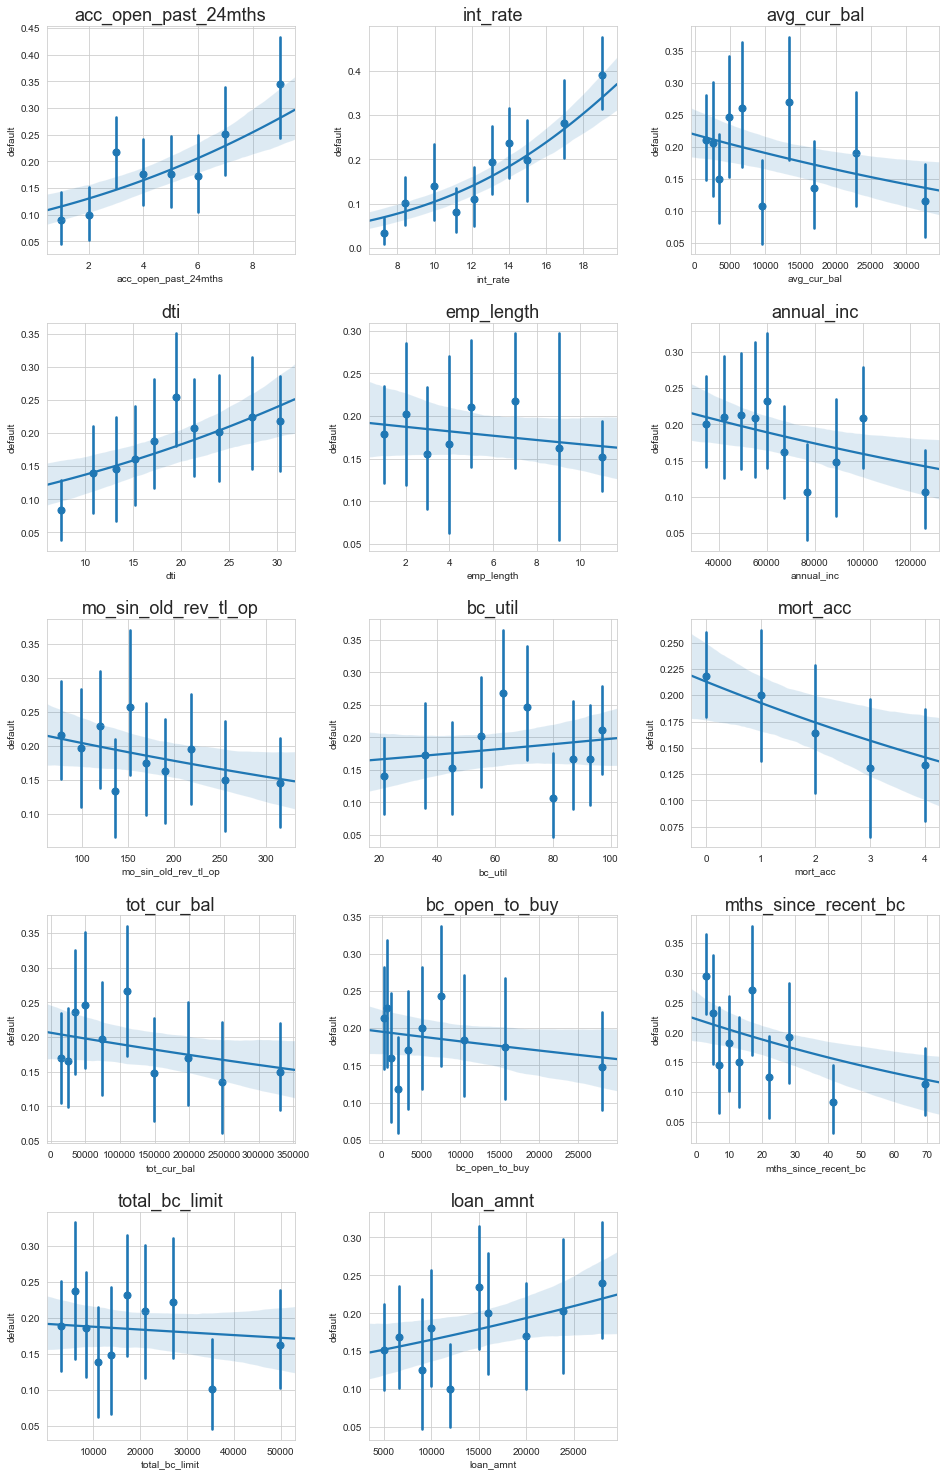

In [34]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16,26))
gs = matplotlib.gridspec.GridSpec(nrows=5, 
                       ncols=3, 
                       figure=fig, 
                       wspace=0.3,
                       hspace=0.3)

ax_dic = {}

counter = 0
for row in range(5):
    for col in range(3):
        if counter < len(features_numeric):
            col_name = features_numeric[counter]
            ax_dic[counter] = fig.add_subplot(gs[row, col])
            sns.regplot(x=col_name, y="default",logistic=True,y_jitter=.03,
                        data=df_train.sample(1000, random_state=666), x_bins=10, ax=ax_dic[counter])
            ax_dic[counter].set_title(col_name,fontsize=18)
            counter +=1
        

In [35]:
percent_missing = round(df_train[features_numeric].isnull().sum() * 100 / df_train.shape[0],2)
min_ = df_train[features_numeric].min()
max_ = df_train[features_numeric].max()

missing_value_df = pd.DataFrame({'column_name': features_numeric,
                                 'percent_missing': percent_missing,
                                'min':min_,
                                 'max':max_
                                })
missing_value_df


column_name  percent_missing     min  \
acc_open_past_24mths  acc_open_past_24mths             4.89    0.00   
int_rate                          int_rate             0.00    5.32   
avg_cur_bal                    avg_cur_bal             6.86    0.00   
dti                                    dti             0.00   -1.00   
emp_length                      emp_length             5.26    0.00   
annual_inc                      annual_inc             0.00    0.00   
mo_sin_old_rev_tl_op  mo_sin_old_rev_tl_op             6.86    3.00   
bc_util                            bc_util             5.84    0.00   
mort_acc                          mort_acc             4.89    0.00   
tot_cur_bal                    tot_cur_bal             6.86    0.00   
bc_open_to_buy              bc_open_to_buy             5.78    0.00   
mths_since_recent_bc  mths_since_recent_bc             5.72    0.00   
total_bc_limit              total_bc_limit             4.89    0.00   
loan_amnt                        loan_amnt             0.00  500.00   

                             max  
acc_open_past_24mths       64.00  
int_rate                   28.99  
avg_cur_bal            958084.00  
dti                       999.00  
emp_length                 11.00  
annual_inc            9550000.00  
mo_sin_old_rev_tl_op      852.00  
bc_util                   339.60  
mort_acc                   52.00  
tot_cur_bal           8000078.00  
bc_open_to_buy         559912.00  
mths_since_recent_bc      616.00  
total_bc_limit        1105500.00  
loan_amnt               40000.00

In [36]:
x = [3]+[3]+[float("inf")]+[-float("inf")]
sorted(list(set(x)))



[-inf, 3, inf]

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import compress
import pandas as pd


class DecisionTreeDiscretizer_DF(BaseEstimator, TransformerMixin):
    
    def __init__(self, max_depth = 3, min_samples_prc_leaf=0.1, bins = None, **kwargs):
        self.max_depth = max_depth
        self.min_samples_prc_leaf = min_samples_prc_leaf
        self.bins = bins
        self.kwargs = kwargs
        
    def fit(self, x, y = None):
        
        #type(x)!=pd.core.frame.DataFrame:
        #    raise ValueError('{} works only with Pandas Data Frame') 
        
        if type(x)==pd.core.frame.DataFrame:
            self.columnNames = x.columns
            self.numberofcolumns = x.shape[1]
            
        if type(x)==pd.core.series.Series:
            self.columnNames = [x.name]
            self.numberofcolumns = 1

        if type(y)==list:
            min_samples_leaf = int(self.min_samples_prc_leaf*len(y))
        else:
            min_samples_leaf = int(self.min_samples_prc_leaf*y.shape[0])
                        
        self.trees = {}
        
        if not self.bins:
            self.bins = {}
        
        for nr_col,name in enumerate(self.columnNames):
            if name not in self.bins.keys():
                self.bins[name] = {}
            
            #self.bins[nr_col]['name'] = self.columnNames[nr_col]
            
            if self.numberofcolumns ==1:
                _df = x.copy()
            else:
                _df = x[name].copy()
            
            _df = _df.to_frame()
            _df['target'] = y
            _df_nona = _df.dropna().copy()
            
            if "bins" not in self.bins[name]:
                self.trees[name] = DecisionTreeClassifier(
                    criterion = 'gini', 
                    random_state=666, 
                    max_depth=self.max_depth, 
                    min_samples_leaf = min_samples_leaf)

                #index 0 becouse _df is only one feature and target
                self.trees[name].fit(_df_nona.iloc[:,0].to_frame(), _df_nona['target'])

                self.bins[name]["bins"] = [-float("inf")]+ \
                        list(sorted(set(self.trees[name].tree_.threshold)))[1:]+[float("inf")]
            else:
                self.bins[name]["bins"] = sorted(list(set(self.bins[name]["bins"])))
                if self.bins[name]["bins"][0] != -float("inf"):
                    self.bins[name]["bins"] = [-float("inf")]+self.bins[name]["bins"]
                if self.bins[name]["bins"][-1] != float("inf"):
                    self.bins[name]["bins"] = self.bins[name]["bins"]+[float("inf")]
        
            #create lower bin bound
            self.bins[name]["bins_l"] = np.array(self.bins[name]["bins"][:-1]).reshape(1,-1)
            #create upper bin bound
            self.bins[name]["bins_u"] = np.array(self.bins[name]["bins"][1:]).reshape(1,-1)
            #creat bin names
            self.bins[name]["bin_names"] = ["NULL"]+ \
                ["["+str(round(i[0],5))+"<->"+str(round(i[1],5))+")" for i in zip(
                    list(self.bins[name]["bins_l"].reshape(-1)),
                    list(self.bins[name]["bins_u"].reshape(-1)))]
        return self
    
    def get_feature_names(self):
        if hasattr(self, "columnNames"):
            return self.columnNames
        else:
            return None  
    
    def transform(self, x):
        
        if type(x)==pd.core.frame.DataFrame:
            _transform_columnNames = x.columns
            _transform_numberofcolumns = x.shape[1]
            
        if type(x)==pd.core.series.Series:
            _transform_columnNames = [x.name]
            _transform_numberofcolumns = 1        
                
        DF = pd.DataFrame()
                
        for nr_col,name in enumerate(_transform_columnNames):
            #select data to discretize and convert to np array
            if _transform_numberofcolumns == 1:
                _data_to_disc = np.array(x).reshape(-1,1)
            else:
                _data_to_disc = np.array(x[name]).reshape(-1,1)
            
            #operacja maciezowa: 
            # 1. Czy wartosc jest wieksza niz donla granica, 2. Czy jest mniejsza niz donla grnaica
            # 3. Wskaz kolumna ktora spelnia punkt 1 i 2 
            _selected_bin = np.logical_and(_data_to_disc>=self.bins[name]["bins_l"],
                                          _data_to_disc<self.bins[name]["bins_u"])
            #
            _selected_bin_arg = np.argmax(_selected_bin,axis=1).reshape(-1,1)
            #fill nan with -99
            _selected_bin_arg[np.isnan(_data_to_disc)] = -99
            
            #create values to change
            if len(_selected_bin_arg[np.isnan(_data_to_disc)])==0:
                _old_values = [-99]+list(np.sort(np.unique(_selected_bin_arg)))
            else:
                _old_values = list(np.sort(np.unique(_selected_bin_arg)))
                
            _name_dic = {}
            
            for i in zip(_old_values,self.bins[name]["bin_names"]):
                _name_dic[i[0]] = i[1] 
                
            _s = pd.Series(pd.Categorical(_selected_bin_arg[:,0], ordered=True))
            #if len(_selected_bin_arg[np.isnan(_data_to_disc)])==0:
            #    _s.cat.add_categories(-99)
            DF[name] = _s.cat.rename_categories(_name_dic)
            
        return DF



In [38]:
tr = DecisionTreeDiscretizer_DF(max_depth = 3, min_samples_prc_leaf=0.05)
#tr.fit_transform(df_train['loan_amnt'],df_train['default'] ).head()
discretized =  tr.fit_transform(df_train[features_numeric],df_train['default'] )


In [39]:
discretized['default'] = df_train['default']
IV_nuemric = {}
for name in discretized.columns[:-1]:
    IV_value, _ = calculate_IV(name, df=discretized, ifprt = False)
    IV_nuemric[name] = IV_value


features_numeric

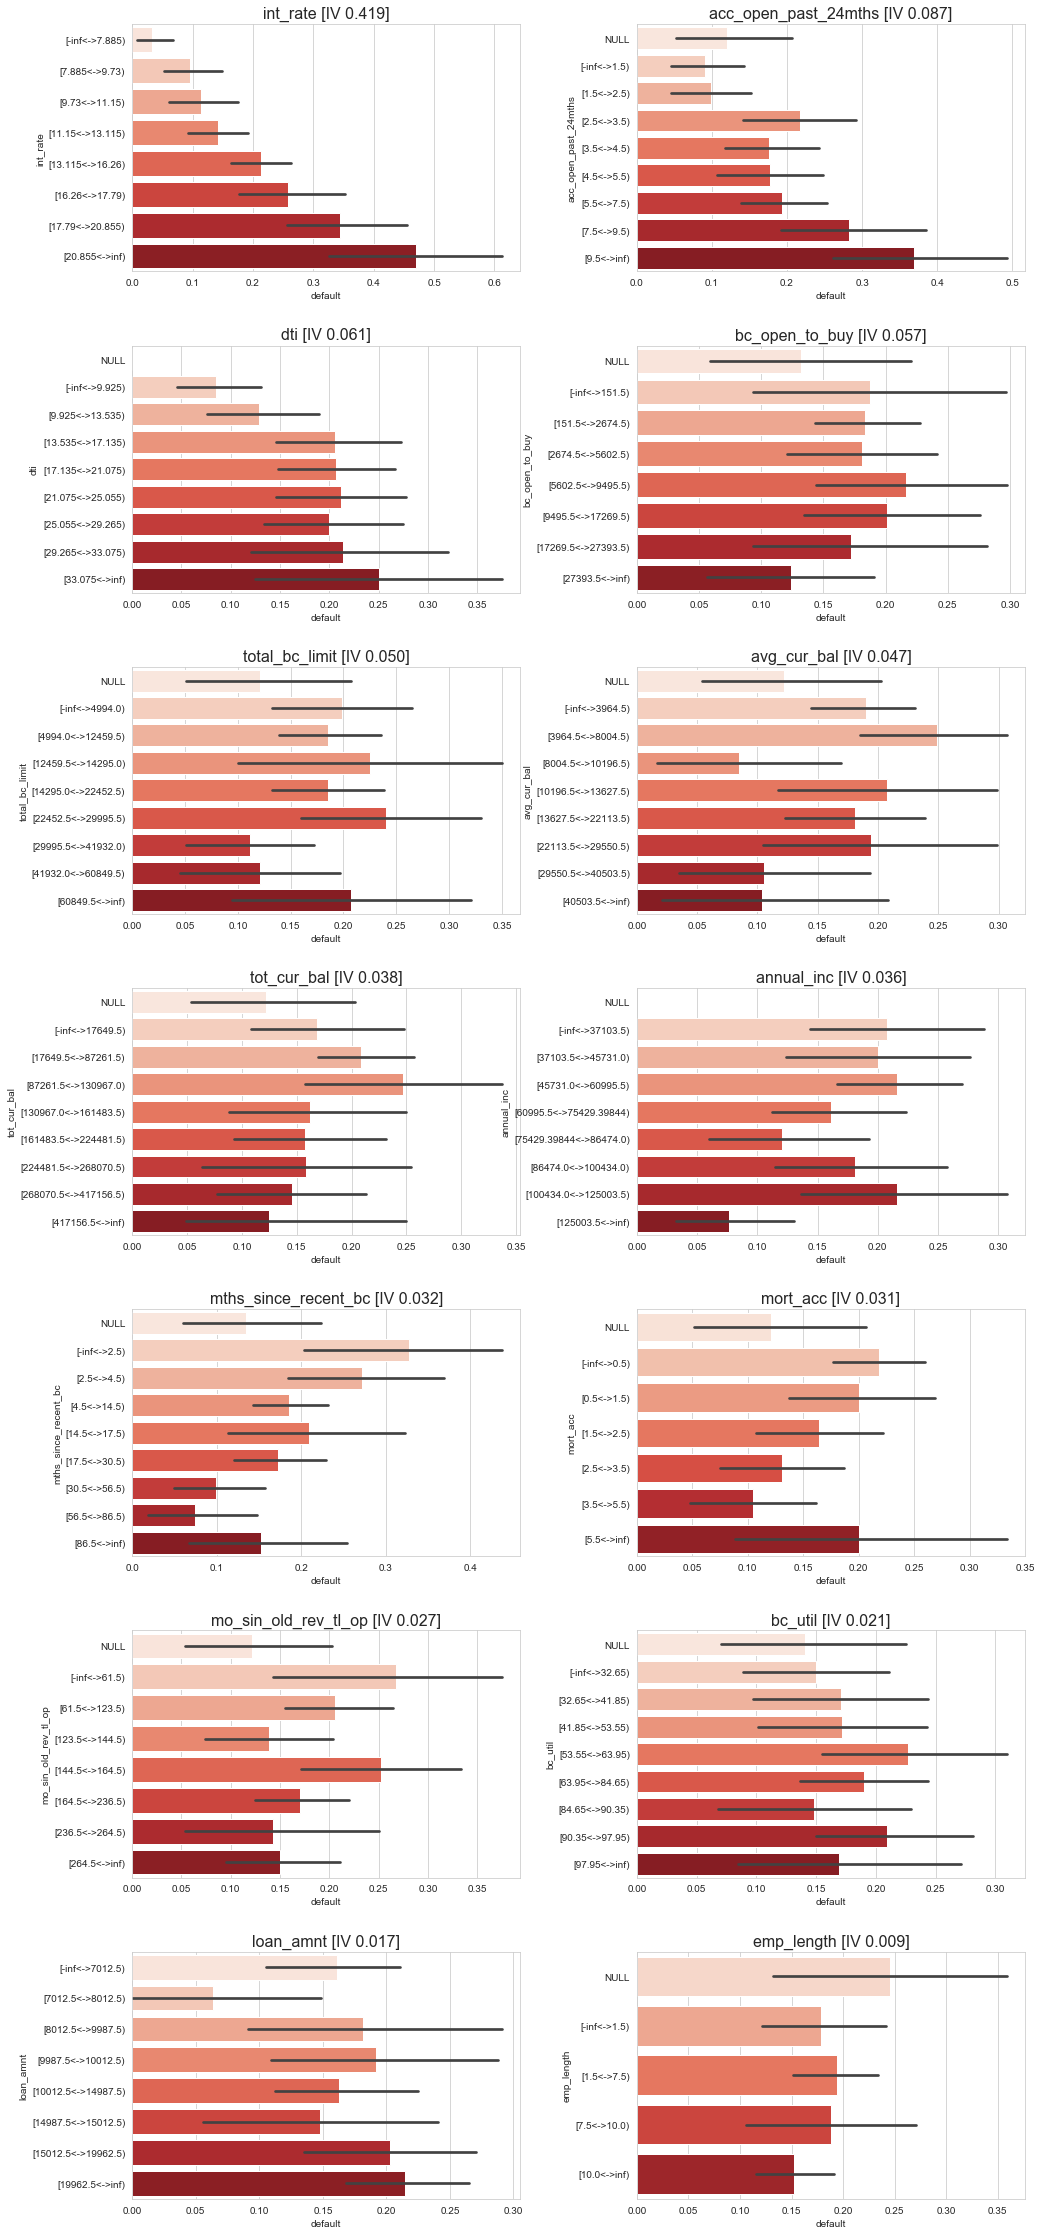

In [40]:
import operator

sns.set_style("whitegrid")
fig = plt.figure(figsize=(16,40))
nrows= 7
ncol = 2
gs = matplotlib.gridspec.GridSpec(nrows=nrows, 
                       ncols=ncol, 
                       figure=fig, 
                       wspace=0.3,
                       hspace=0.3)

ax_dic = {}
features_iv_sort = [i[0] for i in sorted(IV_nuemric.items(), key=operator.itemgetter(1),reverse=True)]
counter = 0
for row in range(nrows):
    for col in range(ncol):
        if counter < len(features_iv_sort):
            col_name = features_iv_sort[counter]
            ax_dic[counter] = fig.add_subplot(gs[row, col])
            #sns.regplot(x=col_name, y="default",logistic=True,y_jitter=.03,
            #            data=df_train.sample(1000, random_state=666), x_bins=10, ax=ax_dic[counter])
            sns.barplot(y=col_name, x="default",data=discretized.sample(1000, random_state=666), palette= 'Reds')
            #Greys,YlGnBu,Greens,YlOrRd,Bluered,RdBu,Reds,Blues,Picnic,Rainbow,Portland,Jet,
            #Hot,Blackbody,Earth,Electric,Viridis,Cividis
            ax_dic[counter].set_title("%s [IV %.3f]"% (col_name,IV_nuemric[col_name]),fontsize=16)
            counter +=1
        

In [41]:
discretized['loan_amnt'].unique()

[[10012.5<->14987.5), [-inf<->7012.5), [9987.5<->10012.5), [14987.5<->15012.5), [15012.5<->19962.5), [19962.5<->inf), [8012.5<->9987.5), [7012.5<->8012.5)]
Categories (8, object): [[-inf<->7012.5) < [7012.5<->8012.5) < [8012.5<->9987.5) < [9987.5<->10012.5) < [10012.5<->14987.5) < [14987.5<->15012.5) < [15012.5<->19962.5) < [19962.5<->inf)]

In [42]:
features_numeric

['acc_open_past_24mths',
 'int_rate',
 'avg_cur_bal',
 'dti',
 'emp_length',
 'annual_inc',
 'mo_sin_old_rev_tl_op',
 'bc_util',
 'mort_acc',
 'tot_cur_bal',
 'bc_open_to_buy',
 'mths_since_recent_bc',
 'total_bc_limit',
 'loan_amnt']

In [43]:
bins_prv = {}
man_bins = {}
for i in tr.bins.keys():
    bins_prv[i] = tr.bins[i]['bins']
for i in tr.bins.keys():
    man_bins[i] = {}

man_bins['int_rate']['bins']=[-np.inf,12,20,np.inf]
man_bins['acc_open_past_24mths']['bins']=[-np.inf,3,9,np.inf]
man_bins['dti']['bins'] = [10,33]
man_bins['bc_open_to_buy']['bins'] = [5000,2000]
man_bins['total_bc_limit']['bins'] = [30000,60000]
man_bins['avg_cur_bal']['bins'] = [10000,30000]
man_bins['tot_cur_bal']['bins'] = [20000,130000]
man_bins['annual_inc']['bins'] = [125000]


In [44]:
man_bins

{'acc_open_past_24mths': {'bins': [-inf, 3, 9, inf]},
 'int_rate': {'bins': [-inf, 12, 20, inf]},
 'avg_cur_bal': {'bins': [10000, 30000]},
 'dti': {'bins': [10, 33]},
 'emp_length': {},
 'annual_inc': {'bins': [125000]},
 'mo_sin_old_rev_tl_op': {},
 'bc_util': {},
 'mort_acc': {},
 'tot_cur_bal': {'bins': [20000, 130000]},
 'bc_open_to_buy': {'bins': [5000, 2000]},
 'mths_since_recent_bc': {},
 'total_bc_limit': {'bins': [30000, 60000]},
 'loan_amnt': {}}

In [45]:
tr_n = DecisionTreeDiscretizer_DF(max_depth = 3, min_samples_prc_leaf=0.05, bins=man_bins)
#tr.fit_transform(df_train['loan_amnt'],df_train['default'] ).head()
discretized_n =  tr_n.fit_transform(df_train[features_numeric],df_train['default'] )
discretized_n['default'] = df_train['default']
IV_nuemric_n = {}
for name in discretized_n.columns[:-1]:
    IV_value, _ = calculate_IV(name, df=discretized_n, ifprt = False)
    IV_nuemric_n[name] = IV_value


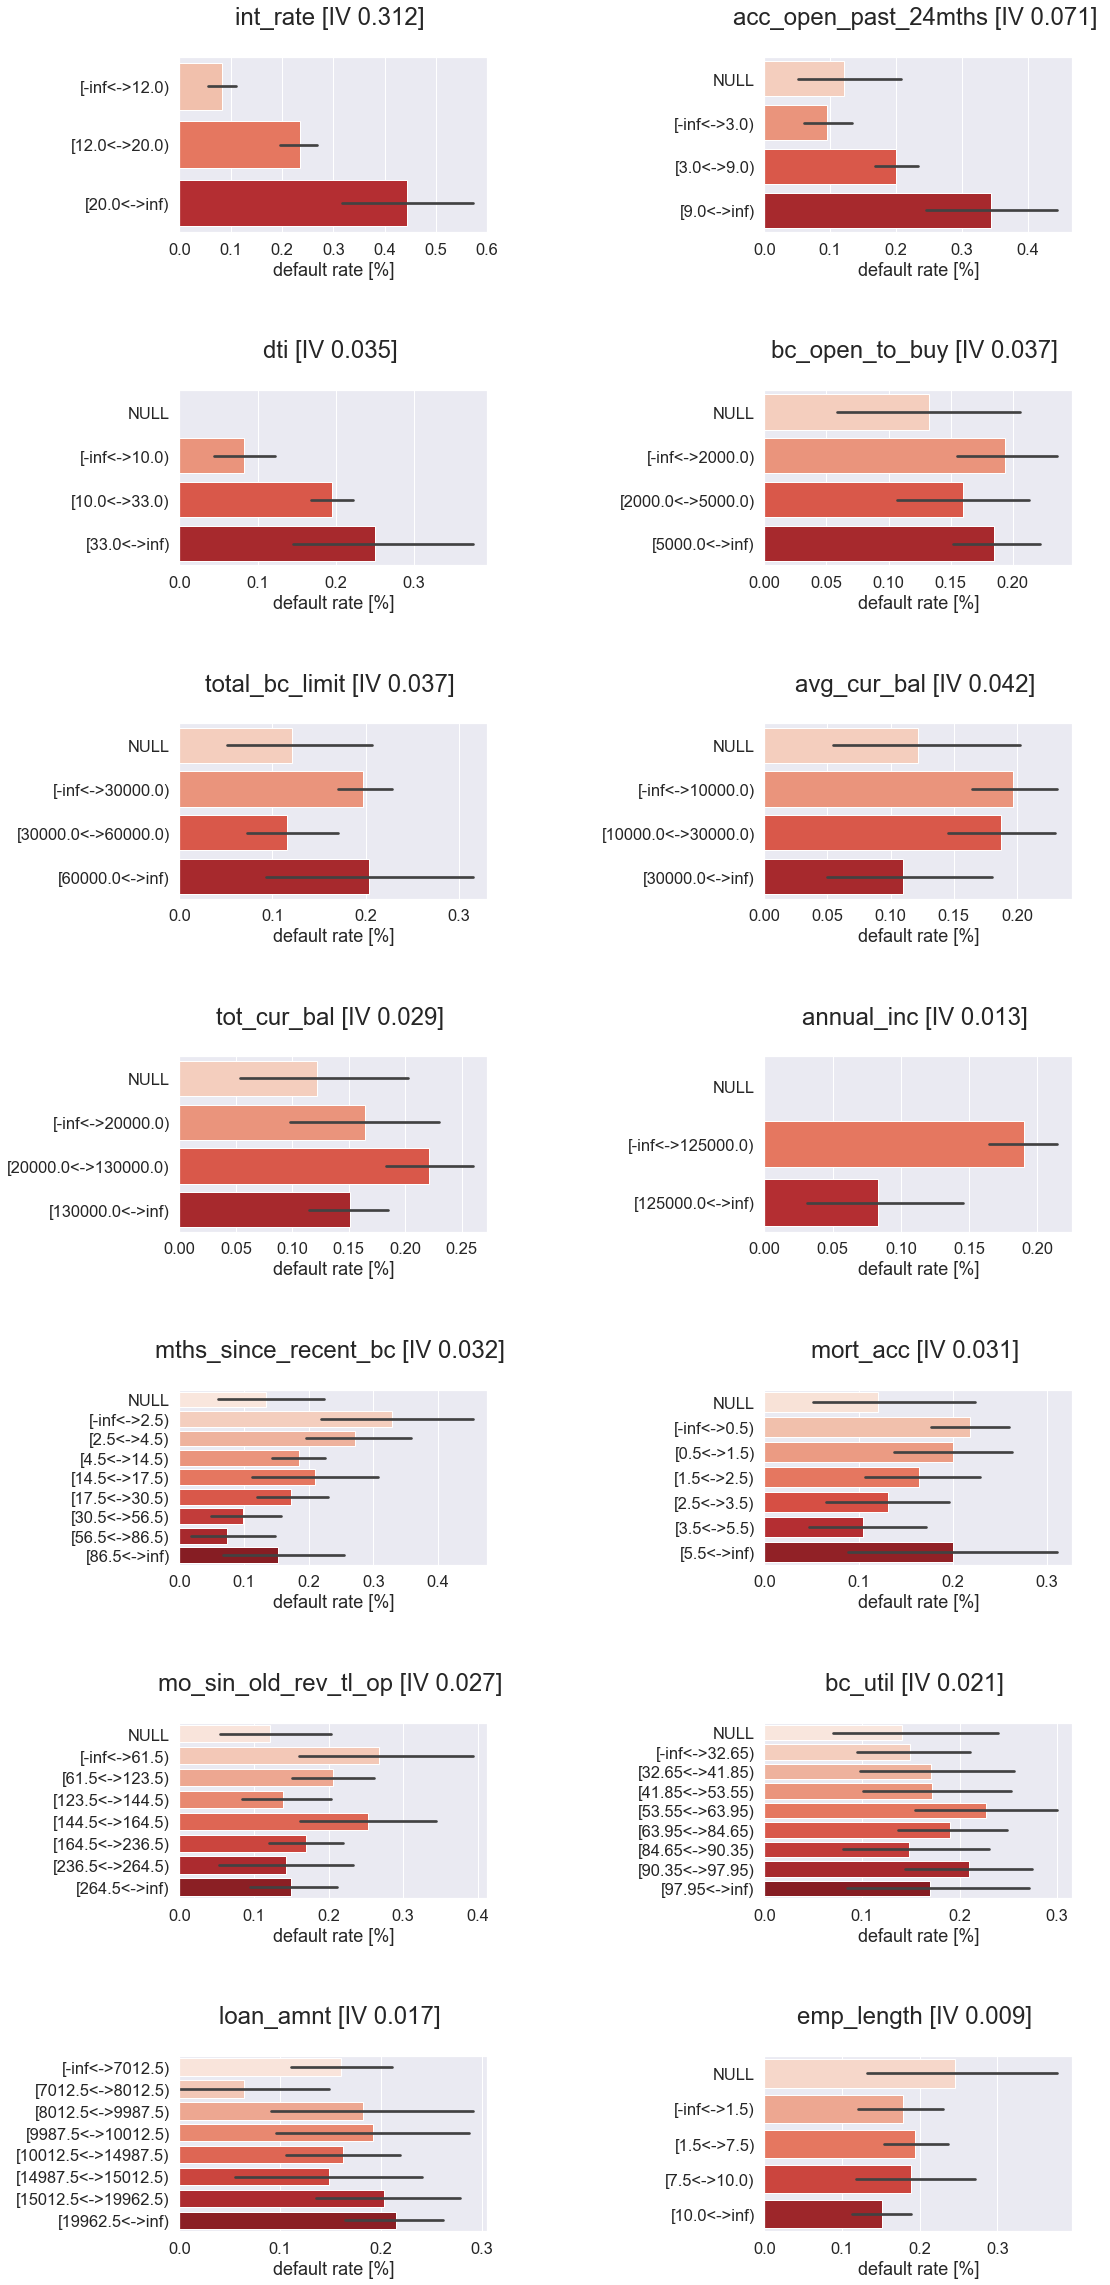

In [79]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16,40))
nrows= 7
ncol = 2
gs = matplotlib.gridspec.GridSpec(nrows=nrows, 
                       ncols=ncol, 
                       figure=fig, 
                       wspace=0.9,
                       hspace=0.9)
sns.set(font_scale = 1.5)

ax_dic = {}
features_iv_sort = [i[0] for i in sorted(IV_nuemric.items(), key=operator.itemgetter(1),reverse=True)]
counter = 0
for row in range(nrows):
    for col in range(ncol):
        if counter < len(features_iv_sort):
            col_name = features_iv_sort[counter]
            ax_dic[counter] = fig.add_subplot(gs[row, col])
            #sns.regplot(x=col_name, y="default",logistic=True,y_jitter=.03,
            #            data=df_train.sample(1000, random_state=666), x_bins=10, ax=ax_dic[counter])
            sns.barplot(y=col_name, x="default",data=discretized_n.sample(1000, random_state=666), palette= 'Reds')
            #Greys,YlGnBu,Greens,YlOrRd,Bluered,RdBu,Reds,Blues,Picnic,Rainbow,Portland,Jet,
            #Hot,Blackbody,Earth,Electric,Viridis,Cividis
            ax_dic[counter].set_title("%s [IV %.3f] \n"% (col_name,IV_nuemric_n[col_name]),fontsize=24)
            ax_dic[counter].set_ylabel('')  
            ax_dic[counter].set_xlabel('default rate [%]') 
            counter +=1
        

In [47]:
IV_cat

{'zip_code': 0.027941173296134353,
 'sub_grade': 0.45488374504047996,
 'addr_state': 0.014000589581223443,
 'home_ownership': 0.028334523770828172,
 'term': 0.11187877821349718}

In [48]:
IV_nuemric

{'acc_open_past_24mths': 0.08746038723921441,
 'int_rate': 0.4193670952941311,
 'avg_cur_bal': 0.04748587628704645,
 'dti': 0.06137983285388187,
 'emp_length': 0.008685111335620756,
 'annual_inc': 0.03574374513150312,
 'mo_sin_old_rev_tl_op': 0.026562616545743396,
 'bc_util': 0.021225004030360692,
 'mort_acc': 0.030779604411806168,
 'tot_cur_bal': 0.03779414254988935,
 'bc_open_to_buy': 0.05694550828005637,
 'mths_since_recent_bc': 0.03217104578411213,
 'total_bc_limit': 0.04983740294599484,
 'loan_amnt': 0.017006957584100063}

In [49]:
IV_nuemric_n

{'acc_open_past_24mths': 0.07060656452169317,
 'int_rate': 0.3121249421823555,
 'avg_cur_bal': 0.04248061141413449,
 'dti': 0.03465820035160508,
 'emp_length': 0.008685111335620756,
 'annual_inc': 0.013152702492669806,
 'mo_sin_old_rev_tl_op': 0.026562616545743396,
 'bc_util': 0.021225004030360692,
 'mort_acc': 0.030779604411806168,
 'tot_cur_bal': 0.029082408639124695,
 'bc_open_to_buy': 0.036920335976666205,
 'mths_since_recent_bc': 0.03217104578411213,
 'total_bc_limit': 0.036804743242539295,
 'loan_amnt': 0.017006957584100063}

# Data features

In [50]:
features_data

['issue_d']

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import compress
import pandas as pd


class DataFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        
    def fit(self, x, y = None):
        if type(x)==pd.core.frame.DataFrame:
            self.columnNames = x.columns
            self.numberofcolumns = x.shape[1]
            
        if type(x)==pd.core.series.Series:
            self.columnNames = [x.name]
            self.numberofcolumns = 1
        return self
    
    def get_feature_names(self):
        if hasattr(self, "columnNames"):
            return self.columnNames
        else:
            return None  
    
    def transform(self, x):
        
        DF = pd.DataFrame()
        
        if type(x)==pd.core.frame.DataFrame:
            _transform_columnNames = x.columns
            
            for nr_col,name in enumerate(_transform_columnNames):
                #select data to discretize and convert to np array
                DF[name+"_month"] = x['name'].dt.month.tolist()
                DF[name+"_quarter"] = x['name'].dt.quarter.tolist()
            
        if type(x)==pd.core.series.Series:
            name = x.name
            DF[name+"_month"] = x.dt.month.tolist()
            DF[name+"_quarter"] = x.dt.quarter.tolist()

        return DF



In [52]:
dat =  DataFeatures()
dat = dat.fit_transform(df_train.issue_d)


In [53]:
tr_d = DecisionTreeDiscretizer_DF(max_depth = 3, min_samples_prc_leaf=0.05)
#tr.fit_transform(df_train['loan_amnt'],df_train['default'] ).head()
discretized_d =  tr_d.fit_transform(dat,df_train['default'] )
discretized_d['default'] = df_train['default']
IV_nuemric_d = {}
for name in discretized_d.columns[:-1]:
    IV_value, _ = calculate_IV(name, df=discretized_d, ifprt = False)
    IV_nuemric_d[name] = IV_value

In [54]:
IV_nuemric_d

{'issue_d_month': 0.0002987427292848985,
 'issue_d_quarter': 0.00021091782514884996}

# Text features

In [55]:
import lightgbm as lgb


In [56]:
import lightgbm as lgb

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,RobustScaler, MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor, Ridge

seed = 6666
max_features_Vectorizer = 10000

pipe = make_pipeline(
    ColumnTransformer([
        ('emp_title', TfidfVectorizer(lowercase=True, 
                               ngram_range=(1, 2), 
                               max_features=max_features_Vectorizer, 
                               dtype=np.float32,
                               use_idf=True),'emp_title'),
        ('desc', TfidfVectorizer(lowercase=True, 
                               ngram_range=(1, 2), 
                               max_features=max_features_Vectorizer, 
                               dtype=np.float32,
                               use_idf=True),'desc'),
        ('title', TfidfVectorizer(lowercase=True, 
                               ngram_range=(1, 2), 
                               max_features=max_features_Vectorizer, 
                               dtype=np.float32,
                               use_idf=True),'title'),
    ]),
    lgb.LGBMClassifier()
    )

In [57]:
df_train.replace({'desc': {'': np.nan},'emp_title': {'': np.nan},'title': {'': np.nan}}, inplace=True)
df_train.fillna({'desc': 'novalue', 'emp_title': 'novalue', 'title': 'novalue'}, inplace=True)

df_test.replace({'desc': {'': np.nan},'emp_title': {'': np.nan},'title': {'': np.nan}}, inplace=True)
df_test.fillna({'desc': 'novalue', 'emp_title': 'novalue', 'title': 'novalue'}, inplace=True)


In [58]:
df_train.columns

Index(['zip_code', 'sub_grade', 'acc_open_past_24mths', 'int_rate',
       'avg_cur_bal', 'dti', 'emp_length', 'addr_state', 'annual_inc',
       'mo_sin_old_rev_tl_op', 'home_ownership', 'bc_util', 'mort_acc',
       'tot_cur_bal', 'bc_open_to_buy', 'term', 'mths_since_recent_bc',
       'total_bc_limit', 'loan_amnt', 'emp_title', 'issue_d', 'default',
       'desc', 'title'],
      dtype='object')

In [59]:
%%time
save = pipe.fit(df_train, df_train.default)

CPU times: user 3min 30s, sys: 5.6 s, total: 3min 35s
Wall time: 1min 23s


In [60]:
from sklearn import metrics

y_pred_train = pipe.predict_proba(df_train)[:,1]
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(df_train['default'], y_pred_train, pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
print("Train AUC= %.3f"% roc_auc_train)
    
y_pred_test = pipe.predict_proba(df_test)[:,1]
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(df_test['default'], y_pred_test, pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)
print("Test AUC= %.3f"% roc_auc_test)  

Train AUC= 0.605
Test AUC= 0.578


In [61]:
import eli5
eli5.show_weights(pipe.named_steps['lgbmclassifier'], 
                  feature_names = pipe.named_steps['columntransformer'].get_feature_names(),
                 top=30)